# Assignment 1

Large-Scale Computing for the Social Sciences

Carly Schippits

In [57]:
import numpy as np
import scipy.stats as sts
import time
from numba.pycc import CC
import matplotlib.pyplot as plt

## 1. a)

In [26]:
# Set model parameters
rho = 0.5
mu = 3.0
sigma = 1.0
z_0 = mu

# Set simulation parameters, draw all idiosyncratic random shocks,
# and create empty containers
S = 1000 # Set the number of lives to simulate
T = int(4160) # Set the number of periods for each simulation
np.random.seed(25)
eps_mat = sts.norm.rvs(loc=0, scale=sigma, size=(T, S))
z_mat = np.zeros((T, S))

def nested_loop(rho, mu, z_0, S, T, eps_mat, z_mat):
  for s_ind in range(S):
    z_tm1 = z_0
    for t_ind in range(T):
      e_t = eps_mat[t_ind, s_ind]
      z_t = rho * z_tm1 + (1 - rho) * mu + e_t
      z_mat[t_ind, s_ind] = z_t
      z_tm1 = z_t
  return z_mat

In [31]:
%time z_mat = nested_loop(rho, mu, z_0, S, T, eps_mat, z_mat)

CPU times: user 2.88 s, sys: 1.75 ms, total: 2.88 s
Wall time: 2.9 s


In [34]:
z_mat = np.zeros((T, S))

cc = CC('test_aot')

@cc.export('nested_loop_aot', 'f8[:,:](f8,f8,f8,i8,i8,f8[:,:],f8[:,:])')
def nested_loop_aot(rho, mu, z_0, S, T, eps_mat, z_mat):
  for s_ind in range(S):
    z_tm1 = z_0
    for t_ind in range(T):
      e_t = eps_mat[t_ind, s_ind]
      z_t = rho * z_tm1 + (1 - rho) * mu + e_t
      z_mat[t_ind, s_ind] = z_t
      z_tm1 = z_t
  return z_mat

cc.compile()

In [36]:
import test_aot

%time z_mat = test_aot.nested_loop_aot(rho, mu, z_0, S, T, eps_mat, z_mat)

CPU times: user 34.4 ms, sys: 0 ns, total: 34.4 ms
Wall time: 34 ms


## 2. a)

In [49]:
rho_vals = list(np.arange(-0.95, 0.95 + 1.9 / 199, 1.9 / 199))

np.random.seed(0)
eps_mat = sts.norm.rvs(loc=0, scale=sigma, size=(T, S))
t_mat = np.zeros(S)
t_mat.fill(T)

In [50]:
cc = CC('test_aot2')

@cc.export('nested_loop_aot2', 'f8(f8,f8,f8,i8,i8,f8[:,:],f8[:])')
def nested_loop_aot2(rho, mu, z_0, S, T, eps_mat, t_mat):
  for s_ind in range(S):
    z_tm1 = z_0
    for t_ind in range(T):
      e_t = eps_mat[t_ind, s_ind]
      z_t = rho * z_tm1 + (1 - rho) * mu + e_t
      if z_t <= 0:
        t_mat[s_ind] = t_ind
        break
      z_tm1 = z_t
  return np.mean(t_mat)

cc.compile()

In [64]:
import test_aot2

results = np.zeros(len(rho_vals))

for i, rho in enumerate(rho_vals):
  results[i] = test_aot2.nested_loop_aot2(rho, mu, z_0, S, T, eps_mat, t_mat)

print('The optimal rho value is', rho_vals[np.argmax(results)], 'with an average of',
      results[np.argmax(results)], 'periods until the first negative health value.')

The optimal rho value is  -0.00477386934673063 with an average of  741 periods until the first negative health value.


##2. b)

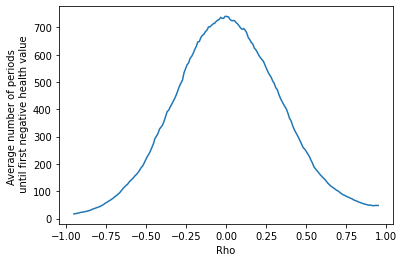

In [62]:
plt.plot(rho_vals, results)
plt.xlabel('Rho')
plt.ylabel('Average number of periods \n until first negative health value')
plt.show()